# Churn Analysis, Insights and Prediction for CX

------
------

### Import all necessary packages

In [1291]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import math

# For customer segmentation clustering purposes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Some probing questions:
# Which company is this, what products it is serving to customers, which industry does it serve?
# Do I need to calculate extra features for the product/company, any other extra features?

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# For training different model algorithms
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Define a custom color palette
light_green_palette = ["#90EE90", "#7CFC00", "#32CD32"]
light_red_palette = ["#FFCCCB", "#FFA07A", "#FF6347"]
churn_palette = ["#FFCCCB"]
not_churn_palette = ["#90EE90"]



### Load the dataset

In [1409]:
# Load the original dataset
df = pd.read_csv("churn_data.xlsx - E Comm.csv")
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


# Exploratory Data Analysis (EDA)

#### Basic data statistics

Based on the values of Coeffifice of variation (CV), many of the features have moderate to high variability. This is an indication of the presence of skewness and outliers in the data which can also be seen through Histograms and Box-plots done later in the sheet.

In [1382]:
# Basic data statistics
basic_stats = df.iloc[:,2:].describe()
basic_stats

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,325.000000


In [1189]:
Counter(df.Churn)

Counter({0: 4682, 1: 948})

In [1417]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

#### Variability in data - Coefficient of Variation (CV)

In [1388]:
# Variability in data
# Calculating Coefficient of variation (CV) = (std/mean)*100

for col in basic_stats.columns:
    std = basic_stats[col]['std']
    mean = basic_stats[col]['mean']
    print(f'CV_{col}:   {round((std/mean)*100)}%')

CV_Tenure:   84%
CV_CityTier:   55%
CV_WarehouseToHome:   55%
CV_HourSpendOnApp:   25%
CV_NumberOfDeviceRegistered:   28%
CV_SatisfactionScore:   45%
CV_NumberOfAddress:   61%
CV_Complain:   158%
CV_OrderAmountHikeFromlastYear:   23%
CV_CouponUsed:   108%
CV_OrderCount:   98%
CV_DaySinceLastOrder:   80%
CV_CashbackAmount:   28%


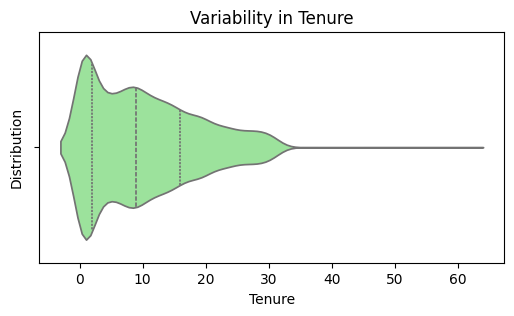

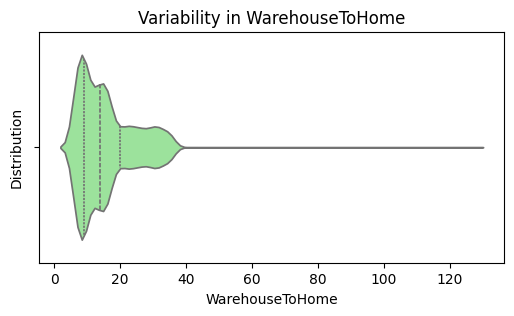

In [1421]:
# Create a violin plot for the 'Tenure' feature
plt.figure(figsize=(6, 3))
sns.violinplot(x='Tenure', data=df, inner='quartile')
plt.title('Variability in Tenure')
plt.xlabel('Tenure')
plt.ylabel('Distribution')
plt.show()

# Create a violin plot for the 'WarehouseToHome' feature
plt.figure(figsize=(6, 3))
sns.violinplot(x='WarehouseToHome', data=df, inner='quartile')
plt.title('Variability in WarehouseToHome')
plt.xlabel('WarehouseToHome')
plt.ylabel('Distribution')
plt.show()

### Determine the categorical and continuous features

In [1063]:
categorical_features = ['PreferredLoginDevice','CityTier','PreferredPaymentMode','Gender','PreferedOrderCat','SatisfactionScore','MaritalStatus','Complain']
continuous_features = ['Tenure','WarehouseToHome','HourSpendOnApp','NumberOfDeviceRegistered','NumberOfAddress','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder','CashbackAmount']


### Check missing values

In [557]:
# Find NaN values in each column
nan_counts = df.isna().sum()
nan_counts

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [1195]:
# Missing values for churning and not-churning customers data
df.query("Churn==0").isna().sum()
df.query("Churn==1").isna().sum()

CustomerID                      0
Churn                           0
Tenure                         81
PreferredLoginDevice            0
CityTier                        0
WarehouseToHome                84
PreferredPaymentMode            0
Gender                          0
HourSpendOnApp                 58
NumberOfDeviceRegistered        0
PreferedOrderCat                0
SatisfactionScore               0
MaritalStatus                   0
NumberOfAddress                 0
Complain                        0
OrderAmountHikeFromlastYear    14
CouponUsed                      8
OrderCount                     18
DaySinceLastOrder              54
CashbackAmount                  0
dtype: int64

In [921]:
# Columns with missing values
nan_columns = nan_counts[nan_counts>0].index
non_nan_columns = (nan_counts[nan_counts==0].index)[2:]

----
### Some of these features seem to have outliers:
Tenure, WarehouseToHome, NumberOfAddress, CoiuponUsed, OrderCount, DaySinceLastOrder

### Plot data distributions of continuous and categorical features
Verify if skewness is present and any strategies we might need to fix them before using them for model training


In [1415]:
# Plot the feature data distributions
def plot_histogram_data_disributions(df, columns):
    """
    df: dataframe to plot the distributions
    columns: columns to plot
    """
    # Data distribution for columns with no Nulls
    subplots_rows = math.ceil(len(columns)/2)
    
    # Create subplots
    fig, axs = plt.subplots(subplots_rows, 2, figsize=(12, 16))
    
    # Flatten the axs array
    axs = axs.flatten()
    
    for i,col in enumerate(columns):
        axs[i].hist(df[col], bins=30, color='blue', alpha=0.7)
        axs[i].set_title(f'{col}')
        axs[i].grid(True)
        # Add a gap between subplots
        plt.subplots_adjust(hspace=1)
    
    # Rotate x-axis labels
    for ax in axs:
        ax.tick_params(axis='x', rotation=45)  # Adjust the rotation angle as needed

# Plot the box-plots to visualize for outliers if any
def plot_boxplots(df, columns):
    """
    df: dataframe to plot the distributions
    columns: columns to plot
    """
    # Data distribution for columns with no Nulls
    subplots_rows = math.ceil(len(columns)/2)
    
    # Create subplots
    fig, axs = plt.subplots(subplots_rows, 2, figsize=(12, 16))
    
    # Flatten the axs array
    axs = axs.flatten()
    
    for i,col in enumerate(columns):
        axs[i].boxplot(df[col].dropna())
        axs[i].set_title(f'{col}')
        axs[i].grid(True)
        # Add a gap between subplots
        plt.subplots_adjust(hspace=1)

# Outliers calclulation for the continous features
def get_outliers(series):
    # Calculate quartiles and IQR
    series = series.dropna()
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1 # Interquartile range
    
    # Identify potential outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_series = series[(series < lower_bound) | (series > upper_bound)]
    return outliers_series

# Missing value imputation
# Mean imputation
def impute_mean(series):
    """
    Imputes the missing values with mean value
    """
    s = series.copy()
    outliers_series = get_outliers(s)
    mean = round(s[~s.index.isin(outliers_series.index)].dropna().mean())
    s[s.isnull()] = mean
    return s

# Median imputation
def impute_median(series):
    """
    Imputes the missing values with median value for high outliers series
    """
    s = series.copy()
    outliers_series = get_outliers(s)
    median = round(s[~s.index.isin(outliers_series.index)].dropna().median())
    s[s.isnull()] = median
    return s

# KNN based imputation
def impute_knn(df_with_nan_columns):
    """
    Takes data frame of all columns with NaN values
    Returns series with imputed values
    """
    # Initialize KNN imputer with desired number of neighbors
    knn_imputer = KNNImputer(n_neighbors=3)  # We can experiment with number of neighbors, for simplicity choosing 3 now
    # Perform imputation on selected features
    return knn_imputer.fit_transform(df_with_nan_columns)


In [1023]:
continuous_features

get_outliers(df.Tenure)

928     50.0
2719    60.0
3743    51.0
5534    61.0
Name: Tenure, dtype: float64

----
# Data Distribution and Outliers: 
### Based on the histograms and box-plots below:
1. Some of the continuous variables seem to be right skewed, a log-transformation might help before using those features for the purpose of training linear models.

   Tenure, WarehouseToHome, CashbackAmount, DaySinceLastOrder
   
3. Following features seem to have outliers:

   Tenure, WarehouseToHome, NumberOfAddress, CoiuponUsed, OrderCount, DaySinceLastOrder, CashBackAmount



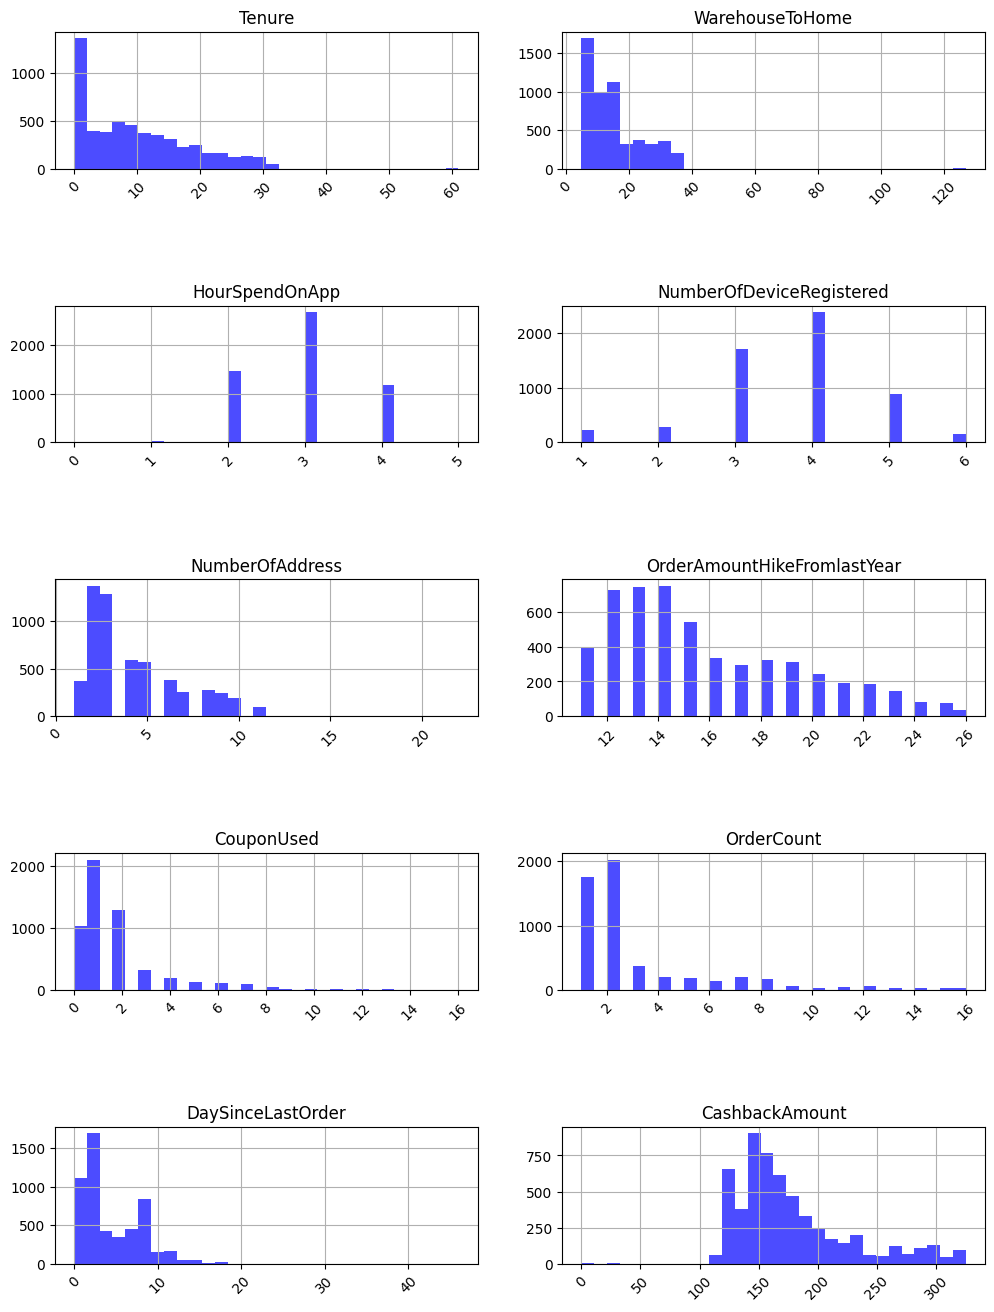

In [925]:
# Plot histograms for continuous features
plot_histogram_data_disributions(df, continuous_features)

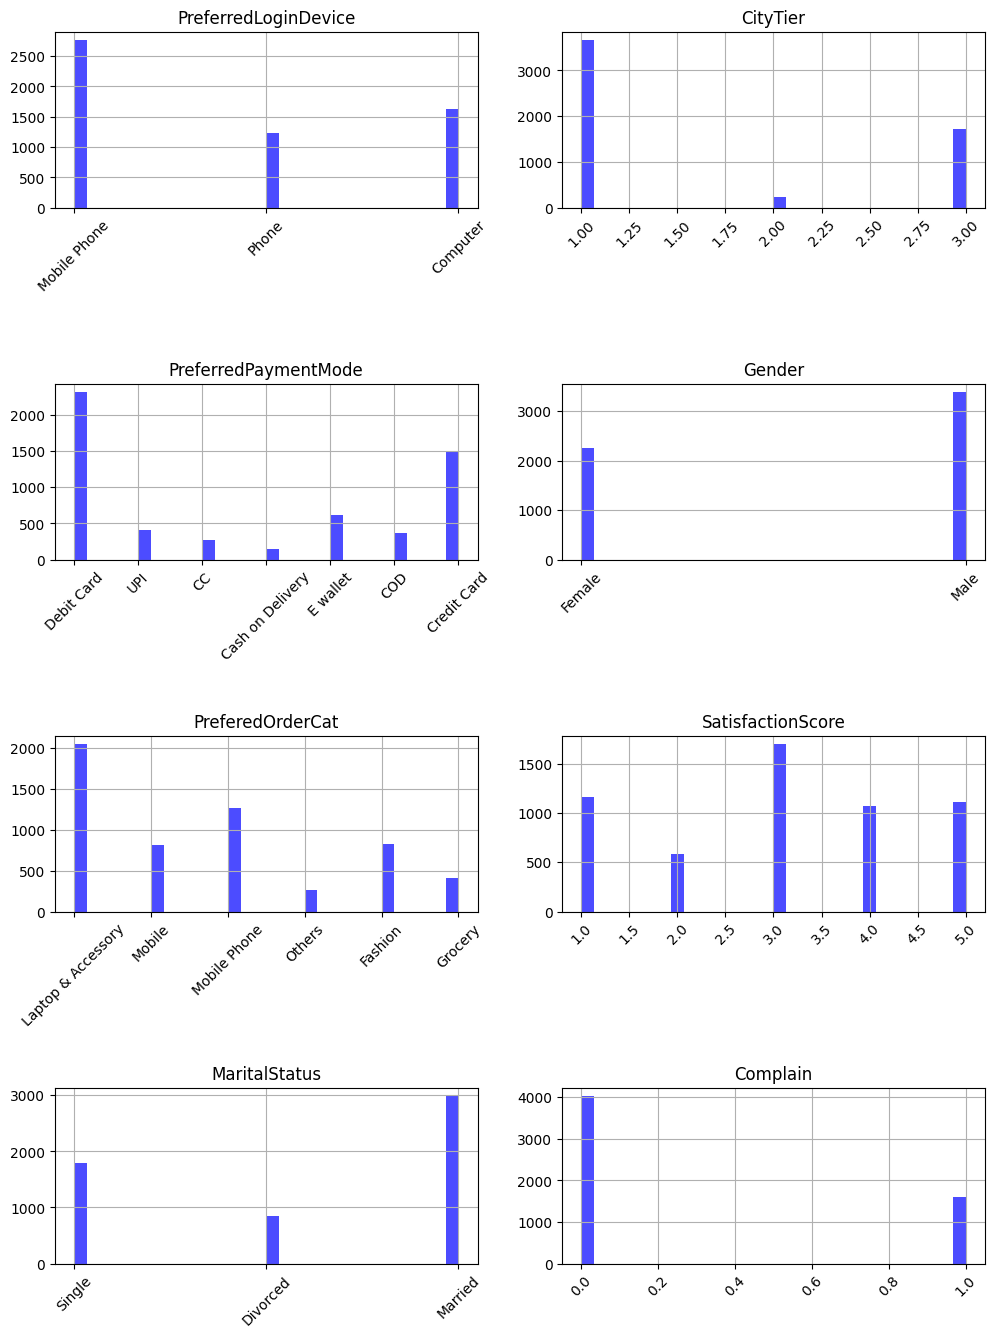

In [967]:
# Plot histograms for categorical features data distibutions
plot_histogram_data_disributions(df, categorical_features)

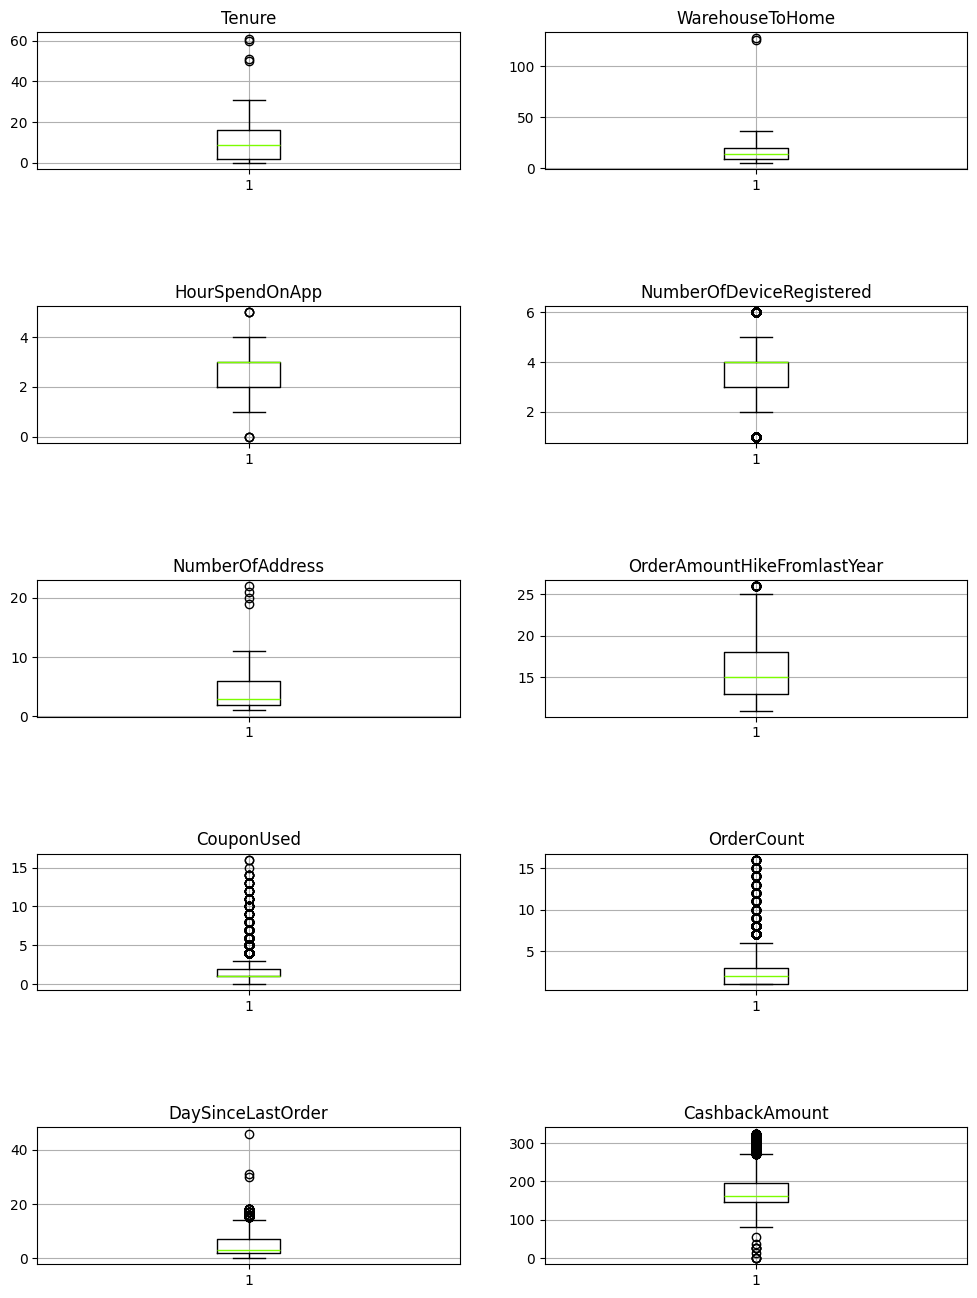

In [1013]:
# Plot box-plots to examine the distributions for continuous features to visualize outliers if any
plot_boxplots(df, continuous_features)


-----
# Correlation analysis

1. OrderCount and CouponUsed seem to be strongly correlated
2. Tenure and CashbackAmount seem to be moderately correlated
3. OrderCount and DaySinceLastOrder seem to be moderately correlated
4. Tenure seems to be moderately correlated with Churn

In [1067]:
f_corr = continuous_features.copy()
f_corr.append('Churn')
f_corr

['Tenure',
 'WarehouseToHome',
 'HourSpendOnApp',
 'NumberOfDeviceRegistered',
 'NumberOfAddress',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount',
 'Churn']

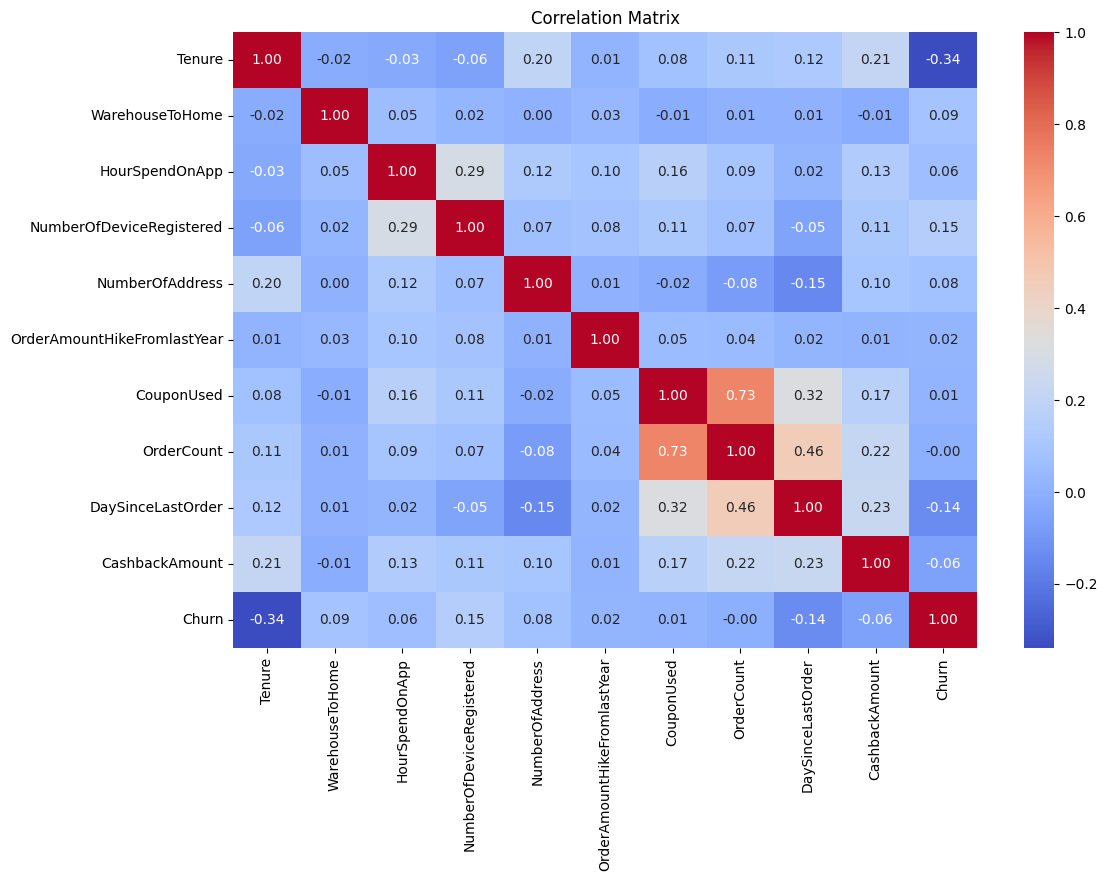

In [1078]:
# Calculate correlation matrix
f_corr = continuous_features.copy()
f_corr.append('Churn')

corr_matrix = df[f_corr].dropna().corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


-----
-----
# Churn distribution Analysis - Which customer segments are more likely to churn?

#### Please Note: 
I have run this analysis without removing any outliers to visualize how they affect the churn. But when building prediction model, I have removed them.

In [840]:
# Helper functions
# Function to visualize churn rate
def visualize_churn_rate_distribution(df, feature):
    """
    df: dataframe to aggregate on
    feature: feature to calculate churn rate
    """
    # Group by feature and calculate the mean of 'Churn'
    churn_rate_by_feature = df.groupby(feature)['Churn'].mean()
    
    # Convert churn rate to percentage
    churn_rate_percentage = churn_rate_by_feature * 100
    
    # Visualize churn distribution
    plt.figure(figsize=(8, 3))
    sns.barplot(x=churn_rate_percentage.index, y=churn_rate_percentage.values, palette=churn_palette)
    plt.title(f"Churn Distribution by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=45)
    plt.show()

# Binning
def get_bins(series, bin_size):
    """
    Returns bins
    """
    counts = series.unique()
    max_count = int(max(counts))
    bins = range(0, max_count+bin_size, bin_size)
    return bins


## 1. Tenure
Understanding why customers leave early in their tenure could provide insights into areas for improvement in the customer onboarding process or early engagement strategies.

#### Insights for CX:
1. The data suggests that customers tend to churn early in their tenure than later.
2. Looking at the box plots, the median tenure for churned customer is around 1 unit of time whereas for not-churned customers, it is around 10 units of time.

#### Recommendations for CX:
1. Review the customer onboarding process or early engagement strategies

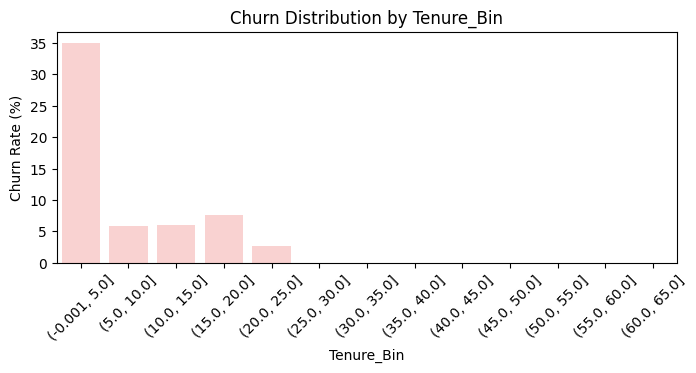

In [890]:
# Visualize churn rate for different Tenure bins

# Load the data
df_tenure_dist = df[['Churn','Tenure']].dropna().copy()

bins = get_bins(df_tenure_dist.Tenure, 5)
df_tenure_dist['Tenure_Bin'] = pd.cut(df_tenure_dist['Tenure'], bins=num_bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_tenure_dist, 'Tenure_Bin')


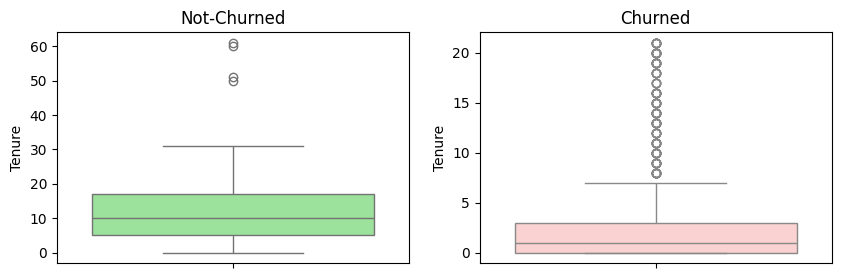

In [710]:
# Box plot to visualize tenure data distribution for churned and not-churned customers

sns.set_palette(light_green_palette)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs = axs.flatten()

sns.boxplot(df[df['Churn']==0].Tenure, ax=axs[0], palette=light_green_palette)
sns.boxplot(df[df['Churn']==1].Tenure, ax=axs[1], palette=light_red_palette)
axs[0].set_title('Not-Churned')
axs[1].set_title('Churned');


## 2. PreferredLoginDevice

Analyzing churn rates based on the preferred login device can reveal whether certain devices are associated with higher churn rates. This insight can inform decisions regarding platform optimization and user experience enhancements tailored to specific devices.

#### Insights for CX:
1. Customers with 'Phone' and 'Computer' as Preferred Login Device have higher churn rates. 

#### Recommendation for CX: 
1. Review the experience on computer browser based company website - website optimization could be considered.
2. Improvement on Phone based logins.


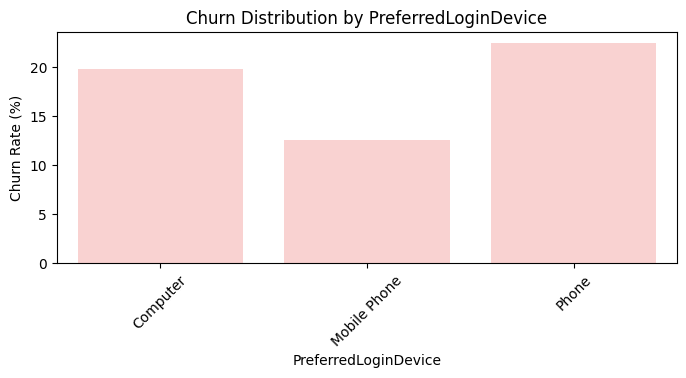

In [709]:
# Visualize the churn rate across different preferred login devices

visualize_churn_rate_distribution(df, 'PreferredLoginDevice')

## 4. Preferred Payment Mode

Studying churn behavior based on preferred payment modes can shed light on payment preferences and satisfaction levels with existing payment options. It can also indicate areas for improvement in payment processing systems or incentives for using preferred payment methods.

#### Insights for CX:
1. Churn rate around COD, CC and E-wallet are higher than other modes.

#### Recommendation for CX:
1. CX might want to encourage customers towards signing up for credit card, debit card etc. payment modes for better customer stickiness.
2. CX might want to get COD, E-wallet processing systems reviewed for any possible issues with them.

In [1051]:
df.groupby(['Churn','PreferredPaymentMode']).agg({'CustomerID':'count'})

CustomerID
Churn PreferredPaymentMode            
0     CC                           214
      COD                          260
      Cash on Delivery             126
      Credit Card                 1308
      Debit Card                  1958
      E wallet                     474
      UPI                          342
1     CC                            59
      COD                          105
      Cash on Delivery              23
      Credit Card                  193
      Debit Card                   356
      E wallet                     140
      UPI                           72

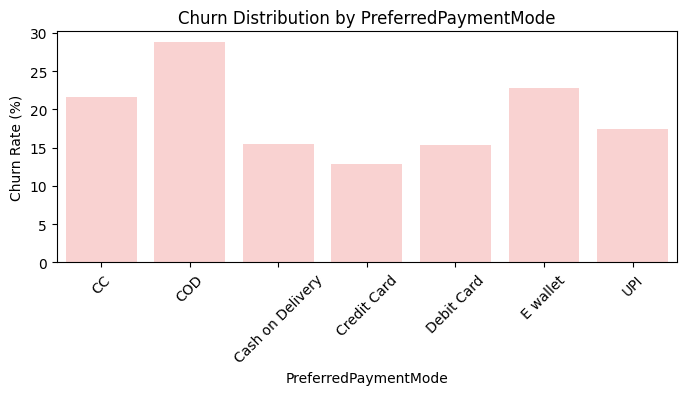

In [712]:
# Visualize the churn rate across different city tiers

visualize_churn_rate_distribution(df, 'PreferredPaymentMode')


# 5. Satisfaction score
Explore the relationship between satisfaction scores and churn. Identify if lower satisfaction scores correlate with higher churn rates, highlighting areas where improvements in customer satisfaction are needed.

Based on the available data, there is no clear indication on the order of satisfaction score from the worst to the best, but based on the churn rate analysis, 5 seems to be the worst score. 
It's not clear from data whether this is a consolidated score for the customer life span or just the last interaction score. If we have the time-based scoring available, we can analyze the rolling averages of the score and assess the satisfcation and its impact on customer experience. This could be a good pointer to flag the customer health score on an on-going basis.

#### Insights for CX:
1. Assuming 5 being the worst satisfaction score, the churn rate is pretty aligned with the satisfaction score.

#### Recommendation for CX:
1. Further qualitative analysis of the feedback data (text analysis with NLP, GenAI/LLMs etc.) may highlight subteties of customer experience and potential improvement areas. 

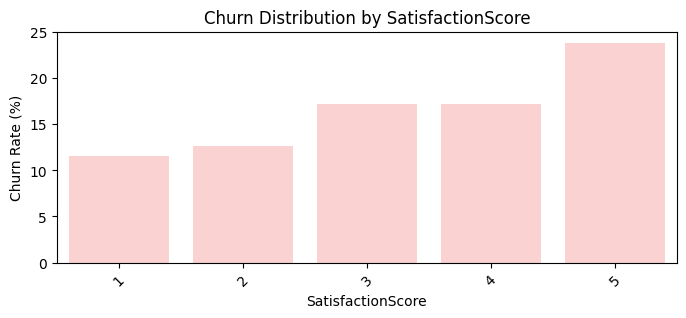

In [715]:
# Visualize the churn rate across different city tiers

visualize_churn_rate_distribution(df, 'SatisfactionScore')


# 6. Complain (any complaint raised in last month)
Investigate the frequency of complaints among churned customers compared to non-churned customers. This can help pinpoint common issues or pain points that lead to churn and guide efforts to address them.

#### Insights for CX:
1. The last month complaints seem to be strongly aligned with the churn rate

#### Recommendation for CX:
1. Further analysis of the complaints would help pin-point issues like complaint resolution time, areas of complaints etc.

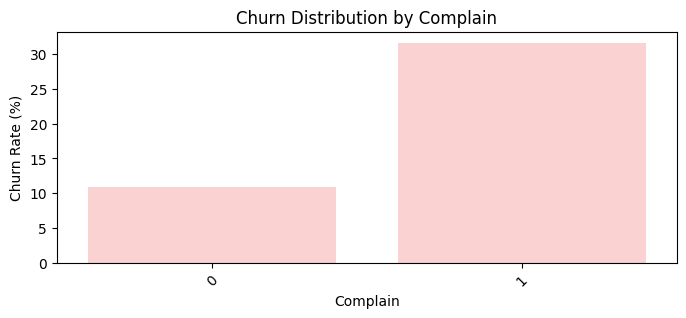

In [723]:
# Visualize the churn rate across customers who had complaints last month vs customers who had none.

visualize_churn_rate_distribution(df, 'Complain')


# 7. Order history:
## Analysis of features: 
#### 'order count', 'coupons used', 'order amount hike', 'Days since last order', and 'Cash back amount'

Analyze the order count,  change in order quantity in last few months (if the data is available), and coupon usage among churned customers. Determine if there are differences in purchasing behavior between churned and non-churned customers that may indicate dissatisfaction with pricing, promotions, order fulfillment process or interaction experiences during the fulfillment process.

#### Insights for CX:
1. The mean value for order count is 3 and any count above 6 is an outlier.
2. Order count, Order amount hike from last year and coupons used, all tell the similar story.
3. The order count, coupons used and order amount hike from last year all together give the same insights, customers who have higher of these features also have higher churn rates. These customers might be just using the coupons and churning.
4. The "Days since last order" visually shows 100% churn for the bin of "45 to 50 days", but there is just 1 customer which has churned. So not enough evidence to confirm on this one. Other than this aberration, maximum churn rate shows for the customers who ordered in last 0 to 5 days, which might indicate problem in order fulfillment or other customer experience issues.
5. Increasing cash back amount seem to suggest lower churn

#### Recommendation for CX:
1. It might be useful to review pricing and promotions. Strategies should be thought of around how to motivate these customers to continue with us.
2. CX should look for the issues in order fulfillment and related customer experiences like customer interacts etc. during the fulfillment process.



In [1040]:
Counter(df_order_dist['OrderCount_Bin'])

# Get ourliers
Counter(get_outliers(df_orderhike_dist.OrderAmountHikeFromlastYear))


Counter({0.0: 265, 26.0: 33})

In [1038]:
df_orderhike_dist.OrderAmountHikeFromlastYear.describe()

count    5630.000000
mean       14.968561
std         4.893091
min         0.000000
25%        13.000000
50%        14.000000
75%        18.000000
max        26.000000
Name: OrderAmountHikeFromlastYear, dtype: float64

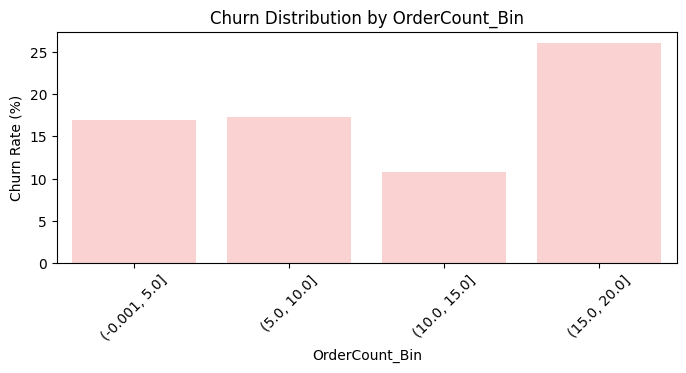

In [891]:
# Visualize churn rate for different order count bins

# Load the relevant data
df_order_dist = df[['Churn','OrderCount']].copy()
df_order_dist.OrderCount.fillna(0, inplace=True) # Fill NaNs with 0, assuming NaNs as 0 order.

# Binning
bin_size=5
bins = get_bins(df_order_dist.OrderCount, bin_size)

df_order_dist['OrderCount_Bin'] = pd.cut(df_order_dist['OrderCount'], bins=bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_order_dist, 'OrderCount_Bin')


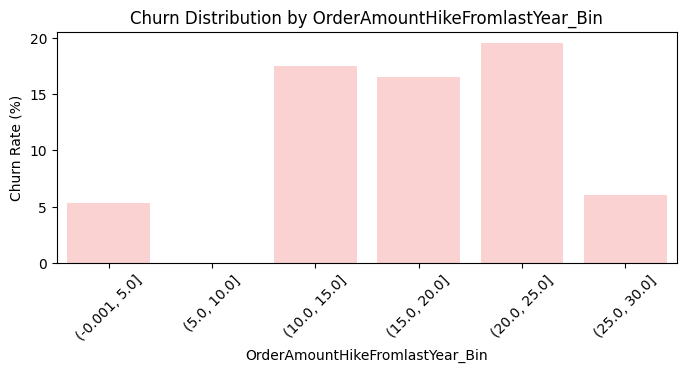

In [893]:
# Visualize churn rate for "hike in order amounts from last year" - calculated for bins

# Some data observations of this feature:
   # Is Tenure in months or years, if in months, how is the OrderAmountHikeFromlastYear > 0 if Tenure=0?
   # Assuming, NaN meaning no hike, we will replace NaNs with 0s, 
   # although we should also consider Tenure in this case and if Tenure < 1 year, just leave the NaNs as is, 
   # but for simplicity, ignoring this here.

# Load the relevant data
df_orderhike_dist = df[['Churn','OrderAmountHikeFromlastYear']].copy()
df_orderhike_dist.OrderAmountHikeFromlastYear.fillna(0, inplace=True) # Fill NaNs with 0, assuming NaNs as 0 order hikes

# Binning
bin_size=5
bins = get_bins(df_orderhike_dist.OrderAmountHikeFromlastYear, bin_size)

df_orderhike_dist['OrderAmountHikeFromlastYear_Bin'] = pd.cut(df_orderhike_dist['OrderAmountHikeFromlastYear'], bins=bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_orderhike_dist, 'OrderAmountHikeFromlastYear_Bin')




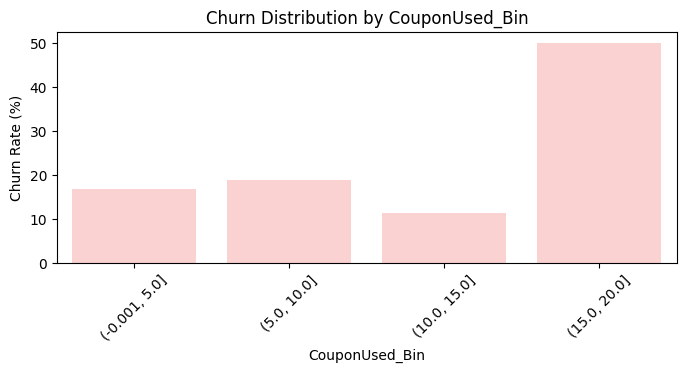

In [970]:
# Visualize churn rate for "Coupons used" bins

# Load the data
df_couponused_dist = df[['Churn','CouponUsed']].copy()
df_couponused_dist.CouponUsed.fillna(0, inplace=True) # Fill NaNs with 0, assuming NaNs as 0 coupons used

# Binning
bin_size=5
bins = get_bins(df_couponused_dist.CouponUsed, bin_size)

df_couponused_dist['CouponUsed_Bin'] = pd.cut(df_couponused_dist['CouponUsed'], bins=bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_couponused_dist, 'CouponUsed_Bin')


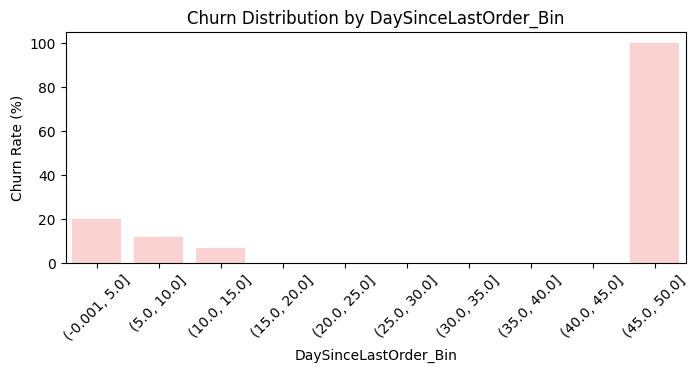

In [974]:
# Visualize churn rate for "days since last order" bins

# Load the data
df_DaySinceLastOrder_dist = df[['Churn','DaySinceLastOrder']].dropna().copy()

# Binning
bin_size=5
bins = get_bins(df_DaySinceLastOrder_dist.DaySinceLastOrder, bin_size)

df_DaySinceLastOrder_dist['DaySinceLastOrder_Bin'] = pd.cut(df_DaySinceLastOrder_dist['DaySinceLastOrder'], bins=bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_DaySinceLastOrder_dist, 'DaySinceLastOrder_Bin')


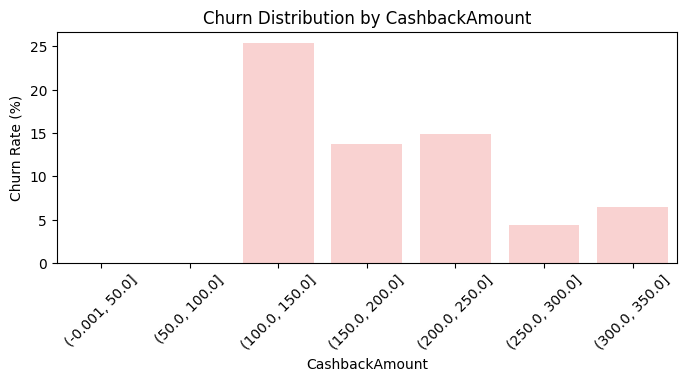

In [989]:
# Visualize churn rate for "cashback amount" bins

# Load the data
df_CashbackAmount_dist = df[['Churn','CashbackAmount']].dropna().copy()

# Binning
bin_size=50
bins = get_bins(df_CashbackAmount_dist.CashbackAmount, bin_size)

df_CashbackAmount_dist['CashbackAmount'] = pd.cut(df_CashbackAmount_dist['CashbackAmount'], bins=bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_CashbackAmount_dist, 'CashbackAmount')


## 7. Demographic Factors - City Tier, Gender, Marital Status

Explore churn rates based on demographic factors such as gender, city tier, marital status, etc. Identify if certain demographic groups are more likely to churn, which can inform targeted retention strategies

#### City Tier

Exploring churn patterns across different city tiers can highlight geographic factors that influence customer retention. Understanding the unique needs and preferences of customers in different city tiers can help tailor marketing strategies and service offerings accordingly.

#### Insights:
Standalone feature insights:
1. Tier 2 and 3 cities seem to be more affected
2. Gender stand-alone seems to have a neutral effect on churn
3. Customers with marital status 'single' are more affected by churn.
Combined feature insights:
1. Between City tier and gender, females from city tier-2 are the most affected by churn.
2. Analyzing the churn rate for all three features combined, following groups seem to be churning the most:
        a. Single females from city tiers 2 and 3
        b. Single males from City tier 1 and 3
        c. Divorced female from City tier 2

#### Recommendation:
1. Tailoring marketing strategies and service offerings around a combination of these insights may help improve customer stickiness.


In [1046]:
Counter(df['CityTier'])

# Get ourliers
#Counter(get_outliers(df.CityTier))


Counter({1: 3666, 3: 1722, 2: 242})

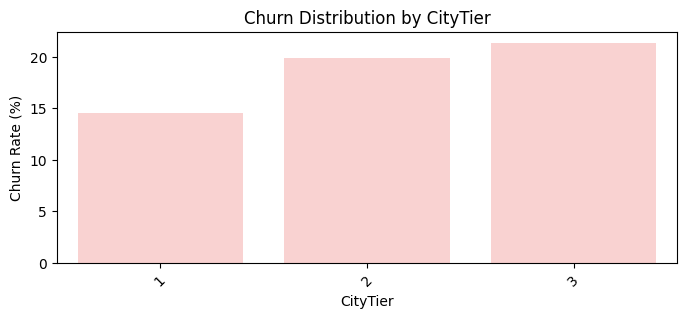

In [711]:
# Visualize the churn rate across different city tiers

visualize_churn_rate_distribution(df, 'CityTier')


In [1047]:
Counter(df['Gender'])


Counter({'Male': 3384, 'Female': 2246})

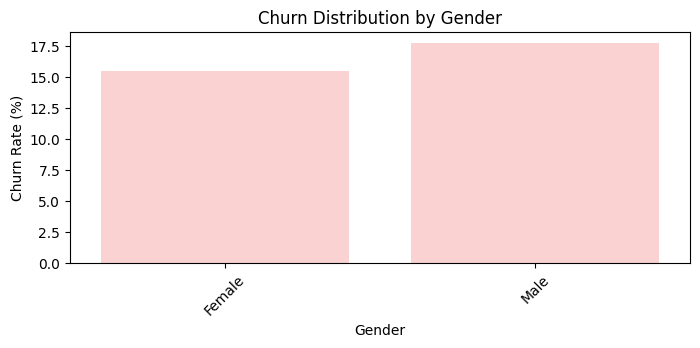

In [900]:
# Visualize the churn rate across different genders

visualize_churn_rate_distribution(df, 'Gender')


In [1048]:
Counter(df['MaritalStatus'])

Counter({'Married': 2986, 'Single': 1796, 'Divorced': 848})

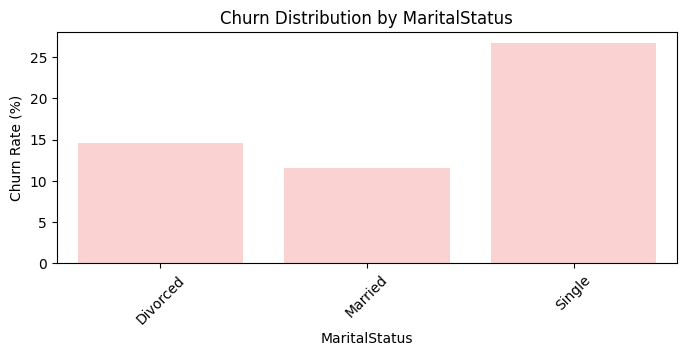

In [901]:
# Visualize the churn rate across different marital status

visualize_churn_rate_distribution(df, 'MaritalStatus')


In [1049]:
Counter(df['NumberOfAddress'])

Counter({2: 1369,
         3: 1278,
         4: 588,
         5: 571,
         6: 382,
         1: 371,
         8: 280,
         7: 256,
         9: 239,
         10: 194,
         11: 98,
         19: 1,
         21: 1,
         20: 1,
         22: 1})

#### The number of customers in the 16-20 and 21-25 bins are pretty small (just 4 customers), that's why we see the anomaly in churn rates.
Although it might not be a typical observation, but being aware of churn rate in the extreme bin is important.

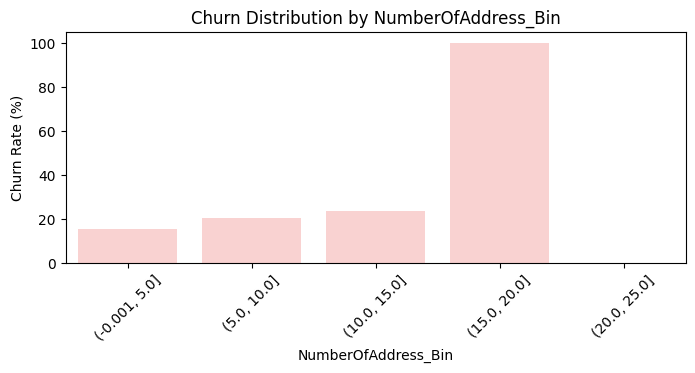

In [1018]:
# Visualize churn rate for "Number of Addresses" bins

# Load the data
df_NumberOfAddress_dist = df[['Churn','NumberOfAddress']].dropna().copy()

# Binning
bin_size=5
bins = get_bins(df_NumberOfAddress_dist.NumberOfAddress, bin_size)

df_NumberOfAddress_dist['NumberOfAddress_Bin'] = pd.cut(df_NumberOfAddress_dist['NumberOfAddress'], bins=bins, include_lowest=True)

# Visualize churn rate for different "Number of address" bins
visualize_churn_rate_distribution(df_NumberOfAddress_dist, 'NumberOfAddress_Bin')


In [1020]:
df_NumberOfAddress_dist.groupby(['Churn','NumberOfAddress_Bin']).agg({'NumberOfAddress':'count'})

NumberOfAddress
Churn NumberOfAddress_Bin                 
0     (-0.001, 5.0]                   3531
      (5.0, 10.0]                     1074
      (10.0, 15.0]                      75
      (15.0, 20.0]                       0
      (20.0, 25.0]                       2
1     (-0.001, 5.0]                    646
      (5.0, 10.0]                      277
      (10.0, 15.0]                      23
      (15.0, 20.0]                       2
      (20.0, 25.0]                       0

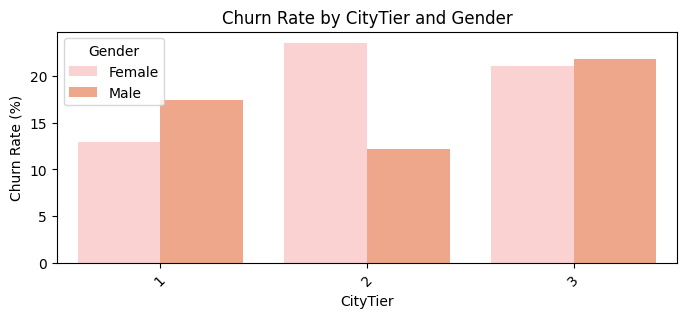

In [966]:
# Create a cross-tabulation for City Tier and Gender
cross_tab = pd.crosstab(index=[df['CityTier'], df['Gender'], df['MaritalStatus']], columns=df['Churn'], normalize='index') * 100

# Reset index to make the DataFrame suitable for plotting
cross_tab = cross_tab.reset_index()

# Plotting
plt.figure(figsize=(8, 3))
sns.barplot(x='CityTier', y=1, hue='Gender', data=cross_tab, palette=light_red_palette, ci=None)
plt.title('Churn Rate by CityTier and Gender')
plt.xlabel('CityTier')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

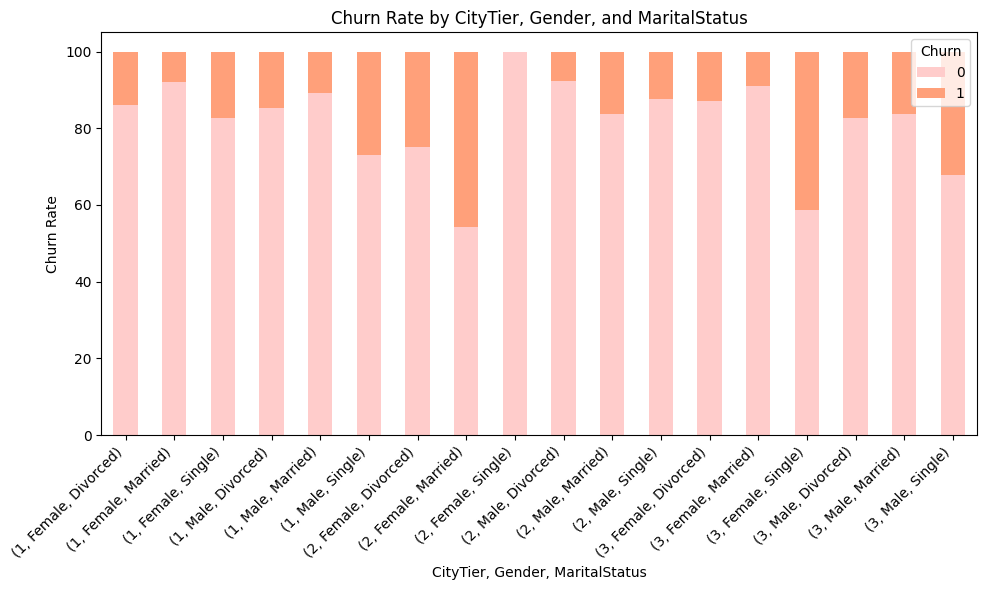

In [962]:
# Calculate churn rate for each combination of demographic features - City Tier, Gender and Marital status
cross_tab = pd.crosstab(index=[df['CityTier'], df['Gender'], df['MaritalStatus']], columns=df['Churn'], normalize='index')*100

# Plot stacked bar plot
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), color=light_red_palette)
plt.title('Churn Rate by CityTier, Gender, and MaritalStatus')
plt.xlabel('CityTier, Gender, MaritalStatus')
plt.ylabel('Churn Rate')
plt.legend(title='Churn')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Hours spent on app

Examine the relationship between the time customers spend on the app and churn. Higher engagement may indicate satisfied customers, while low engagement could signal issues with app usability or content.

### Insights for CX
1. Customers seem to spend a good amount of time on the app.
2. Churn is pretty consistent across different hours of app usage, so no concrete insights can be drawn out of it.
3. Cross relationship between app usage and order count also don't provide much insights.

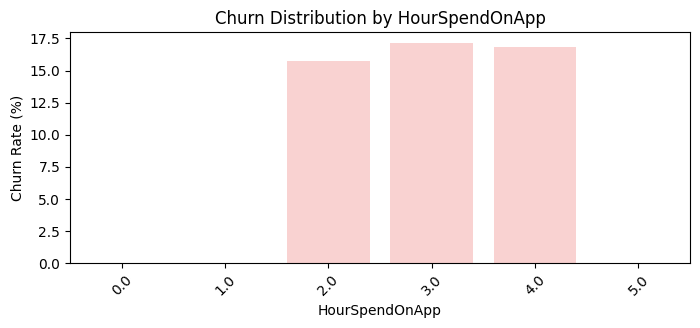

In [1440]:
# Assuming it's daily hours spent
# Do they have difficulty browsing products? What's the time of year where the hours increase or decrease?
# How many times customers end up buying or not after they are done browsing - this can indicate if there are app navigation or other purchase related issues.
# So, working Hours spent with Order count and order amount hike might indicate some relationship

visualize_churn_rate_distribution(df, 'HourSpendOnApp')


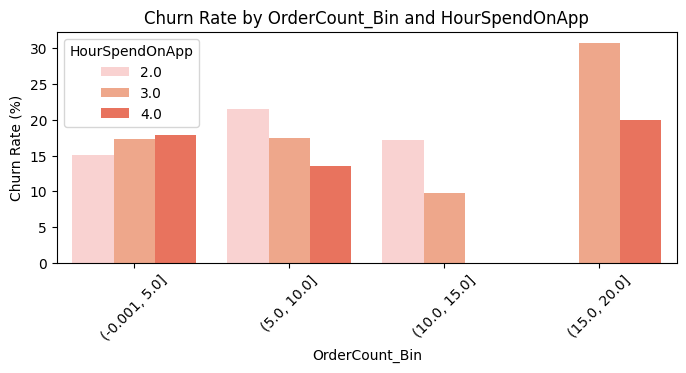

In [1010]:
# Visualize churn rate for different order count bins
# Are customers spending more hours and ordering less? or more?
# Load the relevant data
df_order_hours_dist = df[['Churn','OrderCount','HourSpendOnApp']].copy()
df_order_hours_dist.fillna(0, inplace=True) # Fill NaNs with 0, assuming NaNs as 0 order.
df_order_hours_dist = df_order_hours_dist.query("HourSpendOnApp in (2,3,4)")

# Binning
bin_size=5
bins = get_bins(df_order_hours_dist.OrderCount, bin_size)

df_order_hours_dist['OrderCount_Bin'] = pd.cut(df_order_hours_dist['OrderCount'], bins=bins, include_lowest=True)

# Create a cross-tabulation for City Tier and Gender
cross_tab = pd.crosstab(index=[df_order_hours_dist['OrderCount_Bin'], df_order_hours_dist['HourSpendOnApp']], columns=df['Churn'], normalize='index') * 100

# Reset index to make the DataFrame suitable for plotting
cross_tab = cross_tab.reset_index()

# Plotting
plt.figure(figsize=(8, 3))
sns.barplot(x='OrderCount_Bin', y=1, hue='HourSpendOnApp', data=cross_tab, palette=light_red_palette, ci=None)
plt.title('Churn Rate by OrderCount_Bin and HourSpendOnApp')
plt.xlabel('OrderCount_Bin')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
#plt.legend(title='Gender')
plt.show()



## 9. Warehouse to Home

#### Insights for CX:
1. Churn rates seem to be higher for the Warehouse to home distances of 20 to 40 units.

#### Recommendations:
1. Logistics involved in delivering the product etc. may need review which might be affecting the customer onboarding experience.

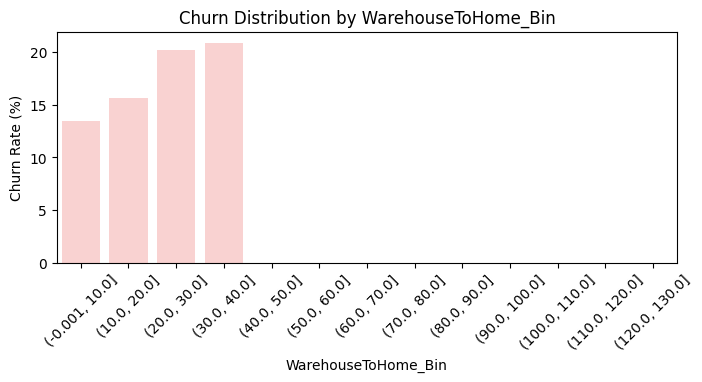

In [1434]:
# Visualize churn rate for different order count bins

# Load the relevant data
df_whtohome_dist = df[['Churn','WarehouseToHome']].copy()

# Binning
bin_size=10
bins = get_bins(df_whtohome_dist.WarehouseToHome, bin_size)

df_whtohome_dist['WarehouseToHome_Bin'] = pd.cut(df_whtohome_dist['WarehouseToHome'], bins=bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_whtohome_dist, 'WarehouseToHome_Bin')

In [1437]:
Counter(df.NumberOfDeviceRegistered)

Counter({4: 2377, 3: 1699, 5: 881, 2: 276, 1: 235, 6: 162})

## 10. Number of devices registered

#### Insights for CX:
1. The data suggest that the churn rate is higher for customers who have more number of devices registered, which is kind of surprising. More devices should be indicative of their commitment to the platform but the data suggest otherwise.

#### Recommendation for CX:
1. The data should be reviewed once more.
2. If the data is right, it might indicate that there is some issue with the platform when the number of registered device increases.

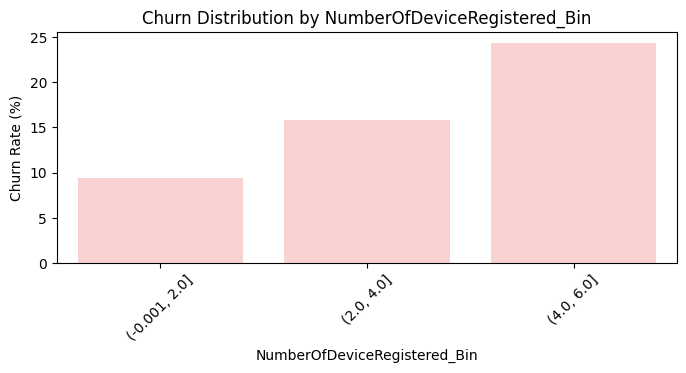

In [1435]:
# Visualize churn rate for different order count bins

# Load the relevant data
df_NumberOfDeviceRegistered_dist = df[['Churn','NumberOfDeviceRegistered']].copy()

# Binning
bin_size=2
bins = get_bins(df_NumberOfDeviceRegistered_dist.NumberOfDeviceRegistered, bin_size)

df_NumberOfDeviceRegistered_dist['NumberOfDeviceRegistered_Bin'] = pd.cut(df_NumberOfDeviceRegistered_dist['NumberOfDeviceRegistered'], bins=bins, include_lowest=True)

# Visualize churn rate for different tenure bins
visualize_churn_rate_distribution(df_NumberOfDeviceRegistered_dist, 'NumberOfDeviceRegistered_Bin')

In [1428]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

-----
# Interaction between features and their effect on Churn

This section tries to analyze the interaction between pair of feataures and the effect it has on churn rate. This could be a good way to build new features.
Some inteaction features created:

### Insights for CX:
1. Customers with PreferredPaymentMode as Credit card has higher churn rate who has preferredLoginDevice as 'Mobile Phone' followed by Computer and Phone.
2. Customers are spending more hours on Phone and Computer and they have high churn rates.

### Recommendation for CX:
1. CX may want to review "credit card" payment process on Mohile phone.
2. CX may want to review and optimize Phone and Computer experiences for customers, could it be navigation issues etc.

----
##### Cross-Category Interaction:
* MaritalStatus and Gender: Interaction between marital status and gender, exploring whether certain combinations have a significant impact on churn.
* PreferredLoginDevice and PreferredPaymentMode: Interaction between preferred login device and preferred payment mode, examining whether certain combinations are associated with higher or lower churn rates.
##### Product Interaction:
* PreferredLoginDevice and HourSpendOnApp: Interaction between the preferred login device and the amount of time spent on the app.
* PreferredPaymentMode and OrderAmountHikeFromlastYear: Interaction between the preferred payment mode and the increase in order amount from last year.
##### Sum/Difference Interaction:
* CityTier and WarehouseToHome: Interaction between the city tier and the distance from the warehouse to the customer's home.
* NumberOfDeviceRegistered and OrderCount: Interaction between the number of devices registered and the total order count.
##### Ratio Interaction:
* HourSpendOnApp and OrderCount: Ratio of the time spent on the app to the total order count.
* NumberOfDeviceRegistered and DaySinceLastOrder: Ratio of the number of devices registered to the days since the last order.
##### Polynomial Interaction:
* SatisfactionScore and OrderAmountHikeFromlastYear: Interaction between customer satisfaction score and the increase in order amount from last year, possibly including squared terms to capture nonlinear relationships.
* NumberOfAddress and NumberOfDeviceRegistered: Interaction between the number of addresses and the number of devices registered, including higher-order polynomial terms.


### Cross-category interaction between pair of categorical features

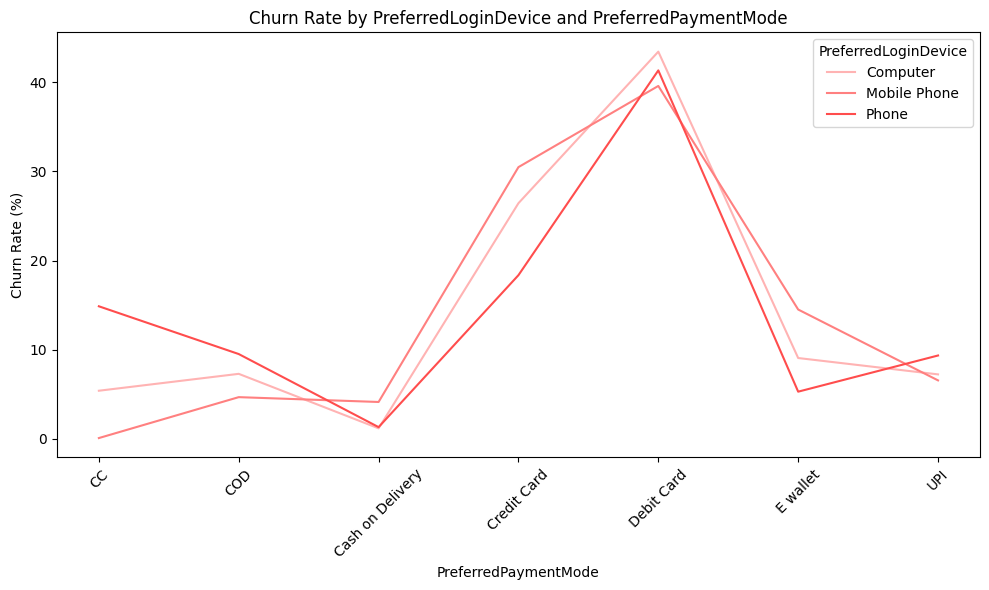

In [1449]:
# Define the categorical features of interest
cat_features = ['PreferredLoginDevice', 'PreferredPaymentMode']

# Create a cross-tabulation (contingency table)
cross_tab = pd.crosstab(df['PreferredLoginDevice'], df['PreferredPaymentMode'])

# Calculate churn rate (percentage of churned customers) for each combination of categories
churn_rate = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Visualize churn rate
plt.figure(figsize=(10, 6))
plt.title('Churn Rate by PreferredLoginDevice and PreferredPaymentMode')
plt.xlabel('PreferredPaymentMode')
plt.ylabel('Churn Rate (%)')

# palette
light_red_shades = [(1.0, 0.7, 0.7), (1.0, 0.5, 0.5), (1.0, 0.3, 0.3)]

for i, category in enumerate(churn_rate.index):
    plt.plot(churn_rate.columns, churn_rate.loc[category], label=category, color=light_red_shades[i])
plt.legend(title='PreferredLoginDevice')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

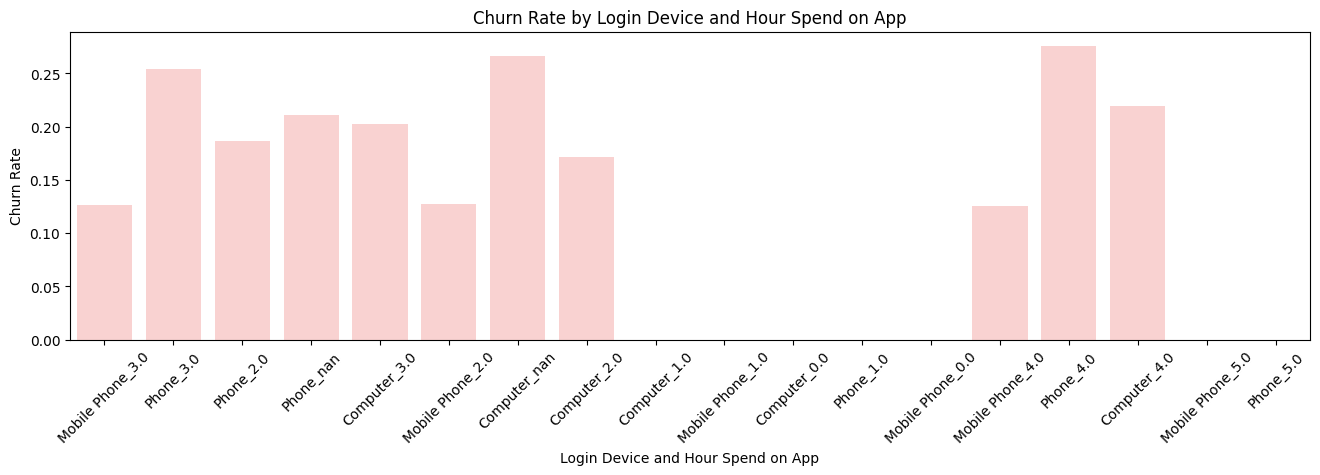

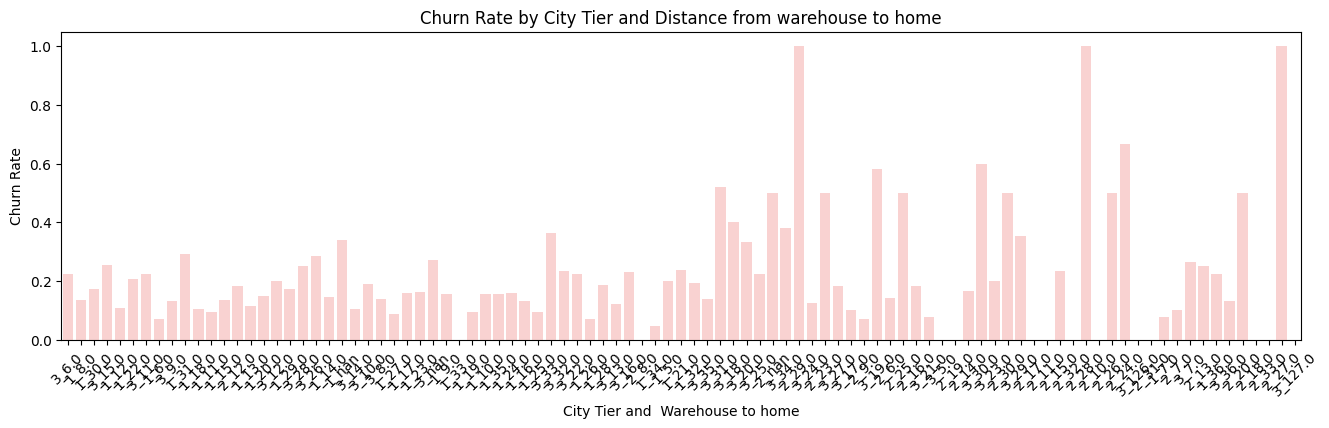

In [1393]:
# Calculate interaction features
df['LoginDevice_HourSpend'] = df['PreferredLoginDevice'] + '_' + df['HourSpendOnApp'].astype(str)
df['PaymentMode_OrderAmountHike'] = df['PreferredPaymentMode'] + '_' + df['OrderAmountHikeFromlastYear'].astype(str)
df['CityTier_WarehouseToHome'] = df['CityTier'].astype(str) + '_' + df['WarehouseToHome'].astype(str)
df['DeviceCount_OrderCount'] = df['NumberOfDeviceRegistered'].astype(str) + '_' + df['OrderCount'].astype(str)
df['HourSpend_OrderCount_Ratio'] = df['HourSpendOnApp'] / df['OrderCount']
df['DeviceCount_DaysSinceLastOrder_Ratio'] = df['NumberOfDeviceRegistered'] / df['DaySinceLastOrder']
df['Satisfaction_OrderAmountHike_Polynomial'] = df['SatisfactionScore'] * df['OrderAmountHikeFromlastYear']
df['Address_DeviceCount_Polynomial'] = df['NumberOfAddress'] * df['NumberOfDeviceRegistered']

# Visualize the effect of interaction features on churn rate
plt.figure(figsize=(16, 4))
sns.barplot(x='LoginDevice_HourSpend', y='Churn', data=df, ci=None, palette=churn_palette)
plt.xticks(rotation=45)
plt.title('Churn Rate by Login Device and Hour Spend on App')
plt.xlabel('Login Device and Hour Spend on App')
plt.ylabel('Churn Rate')
plt.show()

plt.figure(figsize=(16, 4))
sns.barplot(x='CityTier_WarehouseToHome', y='Churn', data=df, ci=None, palette=churn_palette)
plt.xticks(rotation=45)
plt.title('Churn Rate by City Tier and Distance from warehouse to home')
plt.xlabel('City Tier and  Warehouse to home')
plt.ylabel('Churn Rate')
plt.show()

# We can visualize the effect of each interaction feature on churn rate similarly


# Data Pre-processing and Feature Engineering for Prediction Modeling

1. Missing value treatment: K-Means imputation
2. Outlier treatment: I have detected and explored them but I haven't removed them for modeling for the purposes of analysis. In the enterprise setup, as I explore further I would remove them and run the analysis and prediction model once more to compare the results.
3. One-Hot encoding of categorical features 
4. Creating Bins of numerical data as additional features
5. Creating feature interactions as additional features
6. Customer segmentation using K-Means clustering

### Missing values imputation using K-Means


In [1086]:
# KNN based imputation of missing values
def impute_knn(df_nan_columns):
    """
    Takes data frame of all columns with NaN values
    Returns series with imputed values
    """
    # Initialize KNN imputer with desired number of neighbors
    knn_imputer = KNNImputer(n_neighbors=3)  # We can experiment with number of neighbors, for simplicity choosing 3 now
    # Perform imputation on selected features
    return knn_imputer.fit_transform(df_updated[nan_columns])

In [1110]:
# Impute missing values
df_updated = df.copy()
df_updated[nan_columns] = impute_knn(df[nan_columns])
df_updated


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.000000,Mobile Phone,3,6.0,Debit Card,Female,3.000000,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.000000,160
1,50002,1,5.000000,Phone,1,8.0,UPI,Male,3.000000,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.000000,121
2,50003,1,5.666667,Phone,1,30.0,Debit Card,Male,2.000000,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.000000,120
3,50004,1,0.000000,Phone,3,15.0,Debit Card,Male,2.000000,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.000000,134
4,50005,1,0.000000,Phone,1,12.0,CC,Male,2.666667,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.000000,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.000000,Computer,1,30.0,Credit Card,Male,3.000000,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.000000,151
5626,55627,0,13.000000,Mobile Phone,1,13.0,Credit Card,Male,3.000000,5,Fashion,5,Married,6,0,16.0,1.0,2.0,2.333333,225
5627,55628,0,1.000000,Mobile Phone,1,11.0,Debit Card,Male,3.000000,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.000000,186
5628,55629,0,23.000000,Computer,3,9.0,Credit Card,Male,4.000000,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.000000,179


### One-hot Encoding categorical features

Non-ordinal Categorical features that need to be One-Hot Encoded:
1. PreferredLoginDevice
2. PreferredPaymentMode
3. Gender
4. PreferedOrderCat
5. MaritalStatus

In [1139]:
# One-Hot encoding for all the categorical variables
from sklearn.preprocessing import OneHotEncoder

cat_features_for_OH = ['PreferredLoginDevice','PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus']

# Initialize OneHotEncoder with handle_unknown='ignore' and drop the first of the encoded features to avoid multi-collinearity
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

# Fit and transform the encoder to the categories
encoded_categories = encoder.fit_transform(df_updated[cat_features_for_OH])

# Convert the encoded categories to a DataFrame
encoded_df = pd.DataFrame(encoded_categories.toarray(), columns=encoder.get_feature_names_out(cat_features_for_OH))

# Concat this with the original dataframe
df_processed = pd.concat((df_updated, encoded_df), axis=1)
df_processed.drop(columns = cat_features_for_OH, inplace=True)
df_processed

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,50001,1,4.000000,3,6.0,3.000000,3,2,9,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,50002,1,5.000000,1,8.0,3.000000,4,3,7,1,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,50003,1,5.666667,1,30.0,2.000000,4,3,6,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,50004,1,0.000000,3,15.0,2.000000,4,5,8,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,50005,1,0.000000,1,12.0,2.666667,3,5,3,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.000000,1,30.0,3.000000,2,1,6,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5626,55627,0,13.000000,1,13.0,3.000000,5,5,6,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5627,55628,0,1.000000,1,11.0,3.000000,2,4,3,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5628,55629,0,23.000000,3,9.0,4.000000,5,4,4,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Customer Segmentation based on K-Means Clustering  as one feature

Now we run clustering to segment customes based on the feature vectors on the whole dataset including the imputed values. 

#### Clustering may help identify distinct groups of customers based on their behavior, preferences, and characteristics. These segments can represent different personas or customer profiles with unique needs and expectations. Understanding these segments may allow us to tailor their CX strategies to meet the specific requirements of each group effectively.

We will use these clusters as a feature for our prediction model.

Based on the K-Means Elbow graph below, let's consider 4 clusters for the segmentation 

#### Find optimal number of clusters using K-Means elbow graph

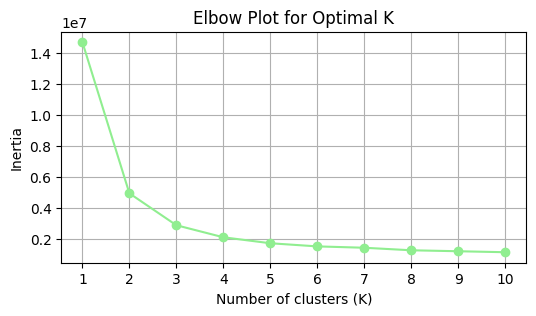

In [1144]:
# Specify the range of clusters (K)
k_values = range(1, 11)  # Try different values of K

inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=99)
    kmeans.fit(df_processed.iloc[:,2:])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 3))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Optimal K')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [1152]:
# Scaling the dataset for customer segmentation clustering using K-Means (Standar SCaler scaling)
def standardize_data(df_to_scale, scaler=StandardScaler()):
    X = df_to_scale
    X_scaled = scaler.fit_transform(X)
    return X_scaled


### Create clusters based on the following features:
'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 
                     'OrderAmountHikeFromlastYear', 'CouponUsed',
                     'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'

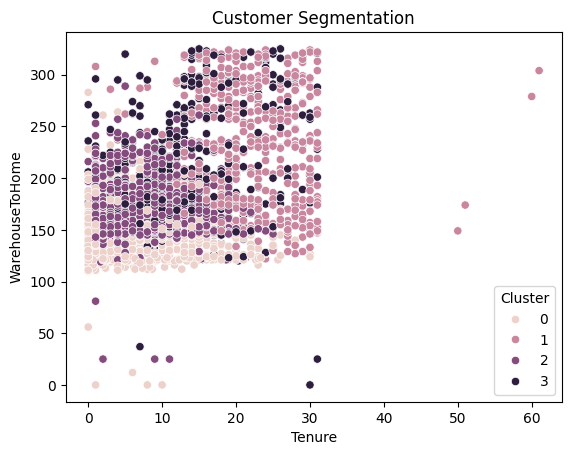

In [1280]:
# Customer segmentation using clustering

features_to_clusters_and_scale = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 
                     'OrderAmountHikeFromlastYear', 'CouponUsed',
                     'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


# Select relevant features for clustering
X = df_processed[features_to_clusters_and_scale]

# Standardize the features
X_scaled = standardize_data(X)

# Perform K-means clustering
optimum_num_clusters = 4
kmeans = KMeans(n_clusters=optimum_num_clusters, random_state=99)
df_processed['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
sns.scatterplot(x='Tenure', y='CashbackAmount', hue='Cluster', data=df_processed)
plt.title('Customer Segmentation')
plt.xlabel('Tenure')
plt.ylabel('WarehouseToHome')
plt.show()

### Combine the dataset with scaled and other features

In [1184]:
df_scaled = pd.DataFrame(X_scaled, columns=features_to_clusters_and_scale)
df_processed[features_to_clusters_and_scale]

df_processed_scaled = df_processed.copy()
df_processed_scaled.drop(columns=features_to_clusters_and_scale, inplace=True)
df_processed_scaled = pd.concat((df_processed_scaled, df_scaled), axis=1)
df_processed_scaled

,CustomerID,Churn,CityTier,SatisfactionScore,Complain,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,PreferredPaymentMode_COD,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,...,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,3,2,1,1.0,0.0,0.0,0.0,0.0,...,-0.717991,-1.145834,0.113675,-0.672900,1.852616,-1.290990,-0.408369,-0.693837,0.111907,-0.350105
1,50002,1,1,3,1,0.0,1.0,0.0,0.0,0.0,...,-0.599832,-0.908124,0.113675,0.303750,1.078430,-0.190639,-0.927514,-0.693837,-1.260722,-1.142957
2,50003,1,1,3,1,0.0,1.0,0.0,0.0,0.0,...,-0.521060,1.706683,-1.284700,0.303750,0.691336,-0.465727,-0.927514,-0.693837,-0.437145,-1.163287
3,50004,1,3,5,0,0.0,1.0,0.0,0.0,0.0,...,-1.190626,-0.076140,-1.284700,0.303750,1.465523,2.010061,-0.927514,-0.693837,-0.437145,-0.878673
4,50005,1,1,5,0,0.0,1.0,0.0,0.0,0.0,...,-1.190626,-0.432705,-0.352450,-0.672900,-0.469944,-1.290990,-0.408369,-0.693837,-0.437145,-0.959991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,1,1,0,0.0,0.0,0.0,0.0,1.0,...,-0.009039,1.706683,0.113675,-1.649551,0.691336,0.634623,-0.408369,-0.354788,-0.162619,-0.533071
5626,55627,0,1,5,0,1.0,0.0,0.0,0.0,1.0,...,0.345438,-0.313850,0.113675,1.280401,0.691336,0.084448,-0.408369,-0.354788,-0.620162,0.971315
5627,55628,0,1,4,1,1.0,0.0,0.0,0.0,0.0,...,-1.072467,-0.551560,0.113675,-1.649551,-0.469944,1.459886,-0.408369,-0.354788,-0.162619,0.178463
5628,55629,0,3,4,0,0.0,0.0,0.0,0.0,1.0,...,1.527025,-0.789269,1.512050,1.280401,-0.082850,-0.190639,0.110775,-0.354788,1.210010,0.036156


-----
-----
# Churn prediction Modeling

Binary Classification models are trained and hypertuned using various Algorithms and train/test datasets and then validated with the hold-out dataset. In the enterprise setup, we can also perform log-transform on some of the right-skewed numeric features data for bringing them closer to normality which would be useful for non-tree algorithms like logistic regression, SVMs.

Dataset splits:
1. train: for training the models
2. val: for validating and tuning hyper-parameters
3. test: for final validation

I have used "Grid Search" with cross-validation for hyper-parameter tuning, although we can also use 'Random Search' if we have a high dimension space.

### Dealing with data imbalance:
For dealing with imbalanced data, we can use oversampling techniques like SMOTE to create synthetic data for minority class and then train the model. I have shown part of the code here but haven't run that as I didn't have time.

### Using groups/bins of the numerical columns as features
I have created bins/groups of data for the numerical features in the churn data segmentation analysis above. We could/should use those as features and try if they help in improving model performance. I couldn't do that because of lack of time.

### Dealing with highly correlated features:
For non-tree based algorithms used, it might be worth exploring the performance of models after removing the highly correlated features identified above through correlation analysis performed. I couldn't perform that due to lack of time.

### Dealing with Outliers
There are outliers present in some of the features which are identified above in the outlier analysis section. I couldn't perform that due to lack of time. 

In [1077]:
# Split the data into train and test sets (80% for cross-validation training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)


Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [1224]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

# Define the parameter grid for each algorithm
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid_xgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'objective': ['binary:logistic'],
    'n_estimators': [100, 200, 300]
}

# Define scoring metrics
scoring = {
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Instantiate the classifiers
rf_classifier = RandomForestClassifier(random_state=99)
lr_classifier = LogisticRegression(random_state=99)
svc_classifier = SVC(random_state=99)
xgb_classifier = xgb.XGBClassifier(random_state=99)

# Create the GridSearchCV objects
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, scoring=scoring, refit='f1_score', cv=5)
grid_search_lr = GridSearchCV(lr_classifier, param_grid_lr, scoring=scoring, refit='f1_score', cv=5)
grid_search_svc = GridSearchCV(svc_classifier, param_grid_svc, scoring=scoring, refit='f1_score', cv=5)
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, scoring=scoring, refit='f1_score', cv=5)


# List of classifiers
classifiers = [
    ('Random Forest', grid_search_rf),
    ('Logistic Regression', grid_search_lr),
    ('Support Vector Classifier', grid_search_svc),
    ('XG Boost Classifier', grid_search_xgb)
]

# Train and tune each classifier
for name, classifier in classifiers:
    print(f'Training and tuning {name}...')
    classifier.fit(X_train, y_train)

# Print the best parameters and scores for each classifier
for name, classifier in classifiers:
    print(f'Best parameters for {name}: {classifier.best_params_}')
    print(f'Best F1 Score for {name}: {classifier.best_score_:.4f}')
    print(f'Best ROC AUC Score for {name}: {classifier.cv_results_["mean_test_roc_auc"][classifier.best_index_]:.4f}')

Training and tuning Random Forest...
Training and tuning Logistic Regression...
Training and tuning Support Vector Classifier...
Training and tuning XG Boost Classifier...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score for Random Forest: 0.8149
Best ROC AUC Score for Random Forest: 0.8586
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}
Best F1 Score for Logistic Regression: 0.6246
Best ROC AUC Score for Logistic Regression: 0.7475
Best parameters for Support Vector Classifier: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 Score for Support Vector Classifier: 0.7648
Best ROC AUC Score for Support Vector Classifier: 0.8320
Best parameters for XG Boost Classifier: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'binary:logistic', 'subsample': 0.8}
Best F1 Score for XG Boost Classifier: 0.

In [1251]:

# Define the parameter grid for each algorithm
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid_xgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'objective': ['binary:logistic'],
    'n_estimators': [100, 200, 300]
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Instantiate the classifiers
rf_classifier = RandomForestClassifier(random_state=99)
lr_classifier = LogisticRegression(random_state=99)
svc_classifier = SVC(random_state=99)
xgb_classifier = xgb.XGBClassifier(random_state=99)

# Use stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

# Create the GridSearchCV objects
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, scoring=scoring, refit='f1_score', cv=skf)
grid_search_lr = GridSearchCV(lr_classifier, param_grid_lr, scoring=scoring, refit='f1_score', cv=skf)
grid_search_svc = GridSearchCV(svc_classifier, param_grid_svc, scoring=scoring, refit='f1_score', cv=skf)
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, scoring=scoring, refit='f1_score', cv=skf)


# List of classifiers
classifiers = [
    ('Random Forest', grid_search_rf),
    ('Logistic Regression', grid_search_lr),
    ('Support Vector Classifier', grid_search_svc),
    ('XG Boost Classifier', grid_search_xgb)
]

# Train and tune each classifier
for name, classifier in classifiers:
    print(f'Training and tuning {name}...')
    classifier.fit(X_train, y_train)

# Print the best parameters and scores for each classifier
for name, classifier in classifiers:
    print(f'Best parameters for {name}: {classifier.best_params_}')
    print(f'Best F1 Score for {name}: {classifier.best_score_:.4f}')
    print(f'Best ROC AUC Score for {name}: {classifier.cv_results_["mean_test_roc_auc"][classifier.best_index_]:.4f}')

Training and tuning Random Forest...
Training and tuning Logistic Regression...
Training and tuning Support Vector Classifier...
Training and tuning XG Boost Classifier...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score for Random Forest: 0.8402
Best ROC AUC Score for Random Forest: 0.8748
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}
Best F1 Score for Logistic Regression: 0.6222
Best ROC AUC Score for Logistic Regression: 0.7462
Best parameters for Support Vector Classifier: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 Score for Support Vector Classifier: 0.7723
Best ROC AUC Score for Support Vector Classifier: 0.8367
Best parameters for XG Boost Classifier: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'binary:logistic', 'subsample': 0.8}
Best F1 Score for XG Boost Classifier: 0.

## Now train and evaluate the best models of each algorithms identified through Grid Search

In [1261]:
# Print the best model parameters learnt through Grid_Search
for name, classifier in classifiers:
    print(f'{name}:{classifier.best_params_}')

Random Forest:{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Logistic Regression:{'C': 10, 'penalty': 'l2'}
Support Vector Classifier:{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
XG Boost Classifier:{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'binary:logistic', 'subsample': 0.8}


In [1389]:
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc


In [1391]:

# Instantiate the best models learnt through grid search
best_model_rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=99)
best_model_lr = LogisticRegression(C= 10, penalty= 'l2', random_state=99)
best_model_svc = SVC(C= 10, gamma= 'scale', kernel= 'rbf', random_state=99)
best_model_xgb = xgb.XGBClassifier(colsample_bytree= 0.8, gamma= 0.1, learning_rate= 0.1, max_depth= 7, min_child_weight= 1, n_estimators= 300, objective= 'binary:logistic', subsample= 0.8, random_state=99)

# Train the best models
best_model_rf.fit(X_train, y_train)
best_model_lr.fit(X_train, y_train)
best_model_svc.fit(X_train, y_train)
best_model_xgb.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = best_model_rf.predict(X_test)
y_pred_lr = best_model_lr.predict(X_test)
y_pred_svc = best_model_svc.predict(X_test)
y_pred_xgb = best_model_xgb.predict(X_test)

# Evaluate the models on the test data for checking how good the model generalizes on the unseen data
predictions = [('Random Forest', y_pred_rf), ('Logistic Regression', y_pred_lr), ('SVM', y_pred_svc), ('XGBoost', y_pred_xgb)]
model_performance_details = []
for name, preds in predictions:
    accuracy, precision, recall, f1, roc_auc = evaluate_model(y_test, preds)
    model_performance_details.append((name, accuracy, precision, recall, f1, roc_auc))

df_test_scores = pd.DataFrame(model_performance_details, columns=['Model_Name', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])
df_test_scores


,Model_Name,Accuracy,Precision,Recall,F1,ROC_AUC
0,Random Forest,0.968028,0.987179,0.819149,0.895349,0.908508
1,Logistic Regression,0.902309,0.809524,0.542553,0.649682,0.758483
2,SVM,0.939609,0.916667,0.702128,0.795181,0.844667
3,XGBoost,0.984014,1.000000,0.904255,0.949721,0.952128


### Training Fully connected Simple neural network with 2 hidden network

In [1401]:
# Training a neural net
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(30,)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC()])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Predict probabilities on the test set
y_pred_proba = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate precision, recall, f1-score, and roc_auc
precision, recall, f1_score = classification_report(y_test, y_pred).split()[-4:-1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"ROC AUC: {roc_auc}")

Epoch 1/10
127/127 [==============================] - 0s 1ms/step - loss: 0.5770 - auc_2: 0.5110 - val_loss: 0.3924 - val_auc_2: 0.7172
Epoch 2/10
127/127 [==============================] - 0s 920us/step - loss: 0.4344 - auc_2: 0.6971 - val_loss: 0.3437 - val_auc_2: 0.8204
Epoch 3/10
127/127 [==============================] - 0s 661us/step - loss: 0.3988 - auc_2: 0.7670 - val_loss: 0.3221 - val_auc_2: 0.8459
Epoch 4/10
127/127 [==============================] - 0s 580us/step - loss: 0.3732 - auc_2: 0.8053 - val_loss: 0.3107 - val_auc_2: 0.8565
Epoch 5/10
127/127 [==============================] - 0s 557us/step - loss: 0.3505 - auc_2: 0.8369 - val_loss: 0.3068 - val_auc_2: 0.8573
Epoch 6/10
127/127 [==============================] - 0s 571us/step - loss: 0.3471 - auc_2: 0.8420 - val_loss: 0.2998 - val_auc_2: 0.8628
Epoch 7/10
127/127 [==============================] - 0s 571us/step - loss: 0.3354 - auc_2: 0.8512 - val_loss: 0.2970 - val_auc_2: 0.8655
Epoch 8/10
127/127 [================

### Traing a Multi-level Perceptron classifier
These results might vary with further data pre-processing, additional features etc.

In [1397]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Assuming X_train, y_train contain the training data
# Define your neural network classifier
nn_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)

# Perform cross-validation with ROC-AUC scoring
roc_auc_scores = cross_val_score(nn_clf, X_train, y_train, cv=5, scoring='roc_auc')

# Print the mean ROC-AUC score and its standard deviation
print("Mean ROC-AUC Score:", roc_auc_scores.mean())
print("Standard Deviation of ROC-AUC Scores:", roc_auc_scores.std())

Mean ROC-AUC Score: 0.9459550903054309
Standard Deviation of ROC-AUC Scores: 0.005951930224027855


-----
## Best Model Performance: XGBoost
-----
-----

----
# Visualize the importance of the features (for XBGoost based Best Model) in predicting the classes
#### F score: 
It represents the number of times a feature appears in a tree across all boosting rounds. Essentially, it measures the importance of a feature based on how frequently it is used to make splits in the trees of the XGBoost model.

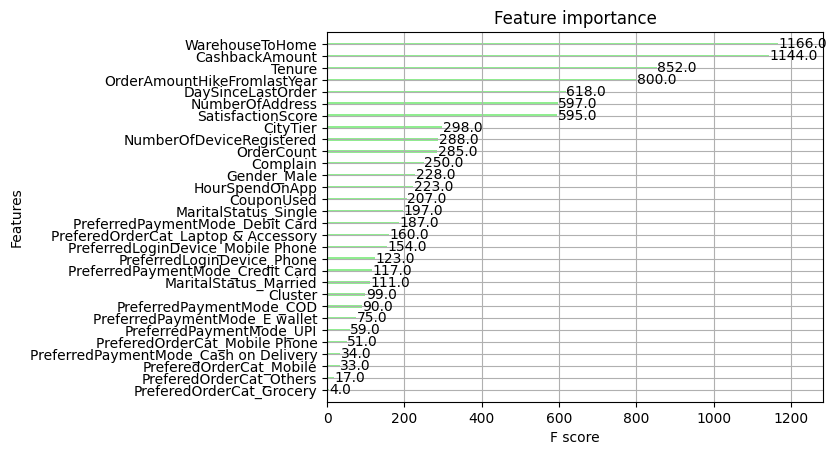

In [1289]:
# Plot feature importance
xgb.plot_importance(best_model_xgb)
plt.show()

# Feature Selection

Based on the feature importance plot from XGBoost, we can visually select top performing features (higher F scores)

### Top performing features: 

WarehouseToHome, CashbackAmount, Tenure, OrderAmountHikeFromLastYear, DaySinceLastOrder, NumberOfAddress etc.

## We can re-train the model with smaller set of features identified based on the best performing features

We can explore further feature selection options as follows:
1. SelectFromModel from sklearn.feature_selection
2. Recursive Feature Elimination (RFE) from sklearn.feature_selection
3. PCA (Principal component analysis) if it's high dimension feature space.


----
## Dealing with Imbalanced Data:
We can apply SMOTE for oversampling the minority class and check how do the models perform.
I haven't done that here due to lack of time, but it can be performed in an enterprise setup.

In [1288]:
### Dealing with imbalance in the data

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Apply SMOTE for oversampling
smote = SMOTE(random_state=99)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialize model
model = RandomForestClassifier()

# Use stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

# And then train the model based on this resampled data using SMOTE

----------
----------
# End of Notebook